In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from sklearn.model_selection import train_test_split
import plotly
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import yfinance as yf

In [69]:
# Importation des données du Bitcoin
btc_hist_data = yf.download('BTC-USD', period='max')

btc_hist_data.index = pd.to_datetime(btc_hist_data.index, unit='s')


target_column = "Close"



[*********************100%%**********************]  1 of 1 completed


In [70]:
btc_hist_data.isna().sum().sum()

0

In [71]:
# Fonction de division du dataset en données de test et données d'entrainement
def t_t_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = t_t_split(btc_hist_data, test_size=0.2)

# Forcer le maintien de la division du datastet à chaquue exécution
seeds = 58

# test_size=  0.2
# # train et test split
# btc_train, btc_test, target_train, target_test = train_test_split(
#         btc_hist, target_btc,
#         test_size=0.2,
#         random_state=seeds
#     )



# # Train et test du datframe initial
# def t_t_split(df, test_size, seeds):
#     btc_train, btc_test,d,f = train_test_split(df,df, test_size=test_size, random_state=seeds)
#     return btc_train, btc_test
# train, test = t_t_split(btc_hist_data, test_size,seeds)


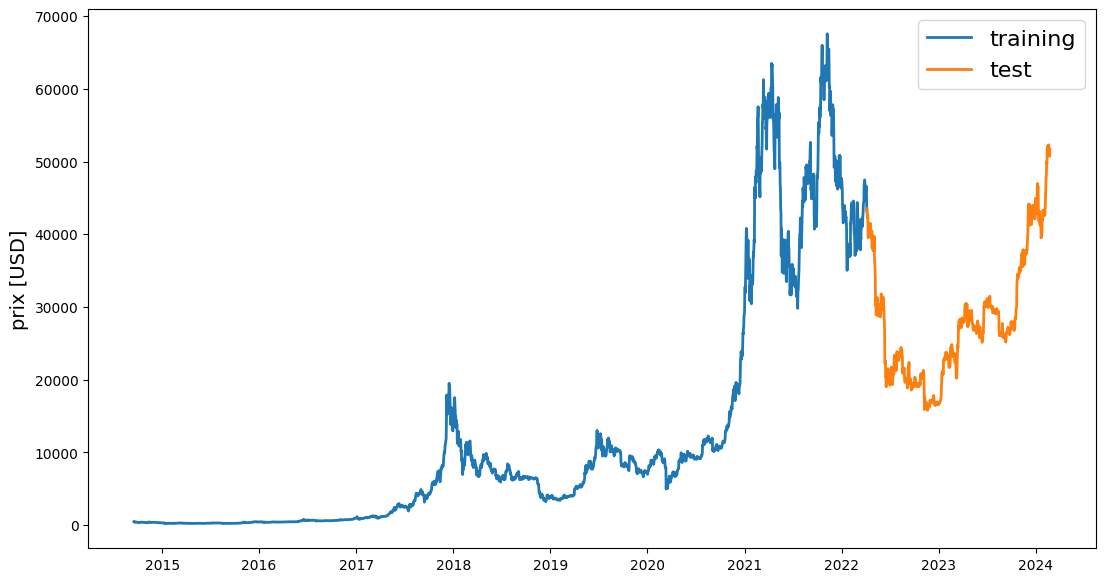

In [72]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('prix [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_column], test[target_column], 'training', 'test', title='')

In [73]:
def normaliser_zero_base(dataframe):
    return dataframe / dataframe.iloc[0] - 1

# Noramliser les données en utilisant le MinMax
def normaliser_min_max(dataframe):
    return (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min())


# Extraire des fenêtres de données de taille 5
def extract_window_data(dataframe, window_lenght=5, zero_base=True):
    window_data = []
    for index in range(len(dataframe) - window_lenght):
        temp_save = dataframe[index: (index + window_lenght)].copy()
        if zero_base:
            temp_save = normaliser_zero_base(temp_save)
        window_data.append(temp_save.values)
    return np.array(window_data)

# # Noramlisation
# scaler = StandardScaler()
# btc_hist_normalised = scaler.fit_transform(btc_hist)

# print(btc_hist_normalised.mean())
# print(btc_hist_normalised.std())

# btc_hist_normalised
# ff = (btc_hist - btc_hist.mean())
# tt = btc_hist.std()
# ff = ff/tt
# print(ff.head(5))
# print(ff.mean())

# # Noramlisation avec MinMaxScaler
# min_max_scaler = MinMaxScaler()
# btc_hist_min_max_norm = min_max_scaler.fit_transform(btc_hist)
# print(btc_hist_min_max_norm)

In [74]:
# La préparation des données 
def prepare_data(btc_hist, target_btc, target_column, window_len=10, zero_base=True):
    train_data, test_data = btc_hist, target_btc
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_column][window_len:].values
    y_test = test_data[target_column][window_len:].values
    
    if zero_base:
        y_train = y_train / train_data[target_column][:-window_len].values - 1
        y_test = y_test / test_data[target_column][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test


In [75]:
temp_save = btc_hist_data[1: (1 + 5)].copy()

temp_save

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600


In [76]:
#La construction du modèle en LSTM
def lstm_model_building(input_data, output_size, neurons=300, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons,  input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

# btc_train.shape[1]

In [77]:
# Les informations desquelles nous nous servirions pour l'utilisation du modèle
np.random.seed(seeds)
window_len = 10
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [78]:
# Utilisation des fonctions de séparation des données
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(train, test, target_column, window_len=window_len, zero_base=True)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=seeds)

# Utilisation du modèle de prédiction construit
model = lstm_model_building(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

# Entrainement du modèle proprement dit
btc_history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_data=(X_val, y_val))

Epoch 1/100
69/69 [==============================] - 32s 88ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 2/100
69/69 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 3/100
69/69 [==============================] - 1s 15ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/100
69/69 [==============================] - 1s 18ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/100
69/69 [==============================] - 1s 21ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 6/100
69/69 [==============================] - 2s 27ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/100
69/69 [==============================] - 1s 21ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 8/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/100
69/69 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 0.001

(2759, 6) (689, 6) (2199, 10, 6) (679, 10, 6) (2199,) (679,)


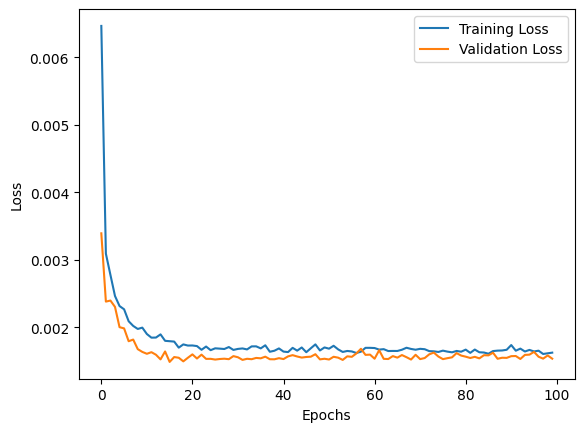

In [79]:
print(train_data.shape, test_data.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape )
# Afficher la courbe de la perte
plt.plot(btc_history.history['loss'], label='Training Loss')
plt.plot(btc_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [80]:
targets = test[target_column][window_len:]
targets =  pd.DataFrame({
    f"{target_column}" : targets
})
preds = model.predict(X_test).squeeze()
print("Moyenne de l'errreur absolue", mean_absolute_error(preds, y_test))
print(targets)


22/22 [==============================] - 2s 4ms/step
Moyenne de l'errreur absolue 0.019362164896004456
                   Close
Date                    
2022-04-17  39716.953125
2022-04-18  40826.214844
2022-04-19  41502.750000
2022-04-20  41374.378906
2022-04-21  40527.363281
...                  ...
2024-02-20  52284.875000
2024-02-21  51839.179688
2024-02-22  51304.972656
2024-02-23  50731.949219
2024-02-24  51639.843750

[679 rows x 1 columns]


In [81]:
# Obtention de la moyenne des prédictions effectuées (des valeurs normées)
mean_preds = (np.mean(preds))
mean_preds

0.0037058603

In [82]:
# print(test[target_column].values[:-window_len] * (preds + 1))
preds = test[target_column].values[:-window_len] * (preds + 1)

preds = pd.DataFrame(
    data = {f'{target_column}':preds}, 
    index= targets.index
)


print(preds)
# line_plot(targets, preds[target_column], 'Valeurs réelles', 'prediction', lw=3)

                   Close
Date                    
2022-04-17  40112.857536
2022-04-18  39374.790549
2022-04-19  40849.481061
2022-04-20  41123.969826
2022-04-21  41178.017635
...                  ...
2024-02-20  51152.245470
2024-02-21  51941.306801
2024-02-22  51706.693271
2024-02-23  51258.230658
2024-02-24  50654.547299

[679 rows x 1 columns]


In [83]:
# Créez un DataFrame avec ces deux séries en tant que colonnes
data = {'Valeurs exactes': targets[target_column], 'Valeurs prédites': preds[target_column]}
compare = pd.DataFrame(data, index=targets.index)

# Affichez le DataFrame
print(compare)

            Valeurs exactes  Valeurs prédites
Date                                         
2022-04-17     39716.953125      40112.857536
2022-04-18     40826.214844      39374.790549
2022-04-19     41502.750000      40849.481061
2022-04-20     41374.378906      41123.969826
2022-04-21     40527.363281      41178.017635
...                     ...               ...
2024-02-20     52284.875000      51152.245470
2024-02-21     51839.179688      51941.306801
2024-02-22     51304.972656      51706.693271
2024-02-23     50731.949219      51258.230658
2024-02-24     51639.843750      50654.547299

[679 rows x 2 columns]


In [84]:
# Prédire pour plusieurs jours à venir
num_days_to_predict = 7
 
# Création d'un dataframe qui contiendra Les valeurs fictives prédites et leurs dates correspondantes
predicted_values_close = pd.DataFrame({})
future_dates = pd.date_range(btc_hist_data.index[-1], periods=num_days_to_predict+1, freq='D')[1:]  # Génération des dates futures
future_dates = pd.to_datetime(future_dates)
btc_change = btc_hist_data
# Génération des valeurs fictives de 7 prochains jours
for future_date in future_dates:
    
    future_data = pd.DataFrame({'Open': np.mean(btc_change.iloc[-num_days_to_predict:]['Open']) * (mean_preds+1), 'High': np.mean(btc_change.iloc[-num_days_to_predict:]['High']) * (mean_preds+1), 'Low': np.mean(btc_change.iloc[-num_days_to_predict:]['Low']) * (mean_preds+1), 'Close': np.mean(btc_change.iloc[-num_days_to_predict:]['Close']) * (mean_preds+1), 'Adj Close': np.mean(btc_change.iloc[-num_days_to_predict:]['Adj Close']) * (mean_preds+1), 'Volume': np.mean(btc_change.iloc[-num_days_to_predict:]['Volume']) * (mean_preds+1)}, index=[future_date])
    btc_change = pd.concat((btc_change, future_data), axis=0)

In [85]:
# Séparation du nouveau dataset en données d'entrainement et de test

train_btc, test_btc = t_t_split(btc_change, test_size=0.2)
test_btc.tail(7)

,Open,High,Low,Close,Adj Close,Volume
2024-02-25,51866.208519,52381.283818,51115.344679,51863.275816,51863.275816,2.334266e+10
2024-02-26,51895.493756,52384.770832,51098.373109,51826.099833,51826.099833,2.416674e+10
2024-02-27,51861.178666,52370.639602,51010.413030,51832.832592,51832.832592,2.456888e+10
2024-02-28,51873.144576,52288.276764,51041.685713,51768.015790,51768.015790,2.330925e+10
2024-02-29,51815.733951,52276.728462,51094.728399,51757.811844,51757.811844,2.254705e+10
2024-03-01,51810.154697,52315.029186,51118.879775,51822.742894,51822.742894,2.213599e+10
2024-03-02,51885.611647,52432.189706,51198.760771,51979.148038,51979.148038,2.223763e+10


In [86]:
# Divsion (de train et test) en données d'entrainement et de test
train_btc_data, test_btc_data, X_btc_train, X_btc_test, y_btc_train, y_btc_test = prepare_data(train_btc, test_btc, target_column, window_len=window_len, zero_base=True)
X_btc_train, X_btc_val, y_btc_train, y_btc_val= train_test_split(X_btc_train, y_btc_train, test_size=0.2, random_state=seeds)
print(y_train.shape)

(2199,)


In [87]:
# Sélection et formation des données des valeurs de la caractéristique cible
targets_btc = test_btc[target_column][window_len:]
targets_btc =  pd.DataFrame({
    f"{target_column}" : targets_btc
})

# Prédiction de données de test
preds_btc = model.predict(X_btc_test).squeeze()

# La moyenne de l'erreur absolue entre les données prédites et le données réelles
print("Moyenne de l'errreur absolue", mean_absolute_error(preds_btc, y_btc_test))
print(targets_btc)


# Dénormalisation des données des valeurs prédites
preds_btc = test_btc[target_column].values[:-window_len] * (preds_btc + 1)

# Création d'un dataframe basé sur les données prédites
preds_btc = pd.DataFrame(
    data = {f'{target_column}':preds_btc}, 
    index= targets_btc.index
)


print(preds_btc)



# Fusion  de deux dataframes (target_btc et preds_btc)
data_btc = {'Valeurs exactes': targets_btc[target_column], 'Valeurs prédites': preds_btc[target_column]}
compare_btc = pd.DataFrame(data_btc, index=targets_btc.index)

# Affichez le DataFrame
print(compare_btc)

22/22 [==============================] - 0s 4ms/step
Moyenne de l'errreur absolue 0.019239879887606275
                   Close
2022-04-22  39740.320312
2022-04-23  39486.730469
2022-04-24  39469.292969
2022-04-25  40458.308594
2022-04-26  38117.460938
...                  ...
2024-02-27  51832.832592
2024-02-28  51768.015790
2024-02-29  51757.811844
2024-03-01  51822.742894
2024-03-02  51979.148038

[681 rows x 1 columns]
                   Close
2022-04-22  40617.294823
2022-04-23  39698.517576
2022-04-24  39167.850497
2022-04-25  39272.480606
2022-04-26  40296.181600
...                  ...
2024-02-27  51546.725825
2024-02-28  51604.301273
2024-02-29  51488.796801
2024-03-01  51597.654218
2024-03-02  51660.505681

[681 rows x 1 columns]
            Valeurs exactes  Valeurs prédites
2022-04-22     39740.320312      40617.294823
2022-04-23     39486.730469      39698.517576
2022-04-24     39469.292969      39167.850497
2022-04-25     40458.308594      39272.480606
2022-04-26     3811

In [88]:
# La visualisation des données (réelles et prédites) de 8 derniers jours
compare_btc.tail(8)

,Valeurs exactes,Valeurs prédites
2024-02-24,51639.843750,50654.547299
2024-02-25,51863.275816,51349.465074
2024-02-26,51826.099833,51705.186838
2024-02-27,51832.832592,51546.725825
2024-02-28,51768.015790,51604.301273
2024-02-29,51757.811844,51488.796801
2024-03-01,51822.742894,51597.654218
2024-03-02,51979.148038,51660.505681


In [89]:
btc_change['Close'].tail(8)

2024-02-24    51639.843750
2024-02-25    51863.275816
2024-02-26    51826.099833
2024-02-27    51832.832592
2024-02-28    51768.015790
2024-02-29    51757.811844
2024-03-01    51822.742894
2024-03-02    51979.148038
Name: Close, dtype: float64

In [90]:
other_test = btc_change.iloc[-7:-1][target_column]

print(other_test)



2024-02-25    51863.275816
2024-02-26    51826.099833
2024-02-27    51832.832592
2024-02-28    51768.015790
2024-02-29    51757.811844
2024-03-01    51822.742894
Name: Close, dtype: float64


In [91]:
preds.index


DatetimeIndex(['2022-04-17', '2022-04-18', '2022-04-19', '2022-04-20',
               '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24',
               '2022-04-25', '2022-04-26',
               ...
               '2024-02-15', '2024-02-16', '2024-02-17', '2024-02-18',
               '2024-02-19', '2024-02-20', '2024-02-21', '2024-02-22',
               '2024-02-23', '2024-02-24'],
              dtype='datetime64[ns]', name='Date', length=679, freq=None)

In [92]:
compare.head(10)

,Valeurs exactes,Valeurs prédites
Date,,
2022-04-17,39716.953125,40112.857536
2022-04-18,40826.214844,39374.790549
2022-04-19,41502.750000,40849.481061
2022-04-20,41374.378906,41123.969826
2022-04-21,40527.363281,41178.017635
2022-04-22,39740.320312,40617.294823
2022-04-23,39486.730469,39698.517576
2022-04-24,39469.292969,39167.850497
2022-04-25,40458.308594,39272.480606


In [93]:
compare.describe()

,Valeurs exactes,Valeurs prédites
count,679.000000,679.000000
mean,27853.333662,27749.010119
std,8383.906467,8326.238625
min,15787.284180,15687.387566
25%,21154.375000,20998.787324
50%,26851.277344,26713.462355
75%,30406.768555,30334.402564
max,52284.875000,52520.657386


In [94]:
print(model.predict(X_test))

22/22 [==============================] - 0s 5ms/step
[[-7.79469237e-02]
 [-6.88823387e-02]
 [-4.51743752e-02]
 [-2.56754924e-02]
 [ 4.19036895e-02]
 [ 1.22139081e-02]
 [-3.56650651e-02]
 [-1.92226190e-02]
 [-3.15875411e-02]
 [-3.17387097e-03]
 [-4.50330079e-02]
 [-4.17050496e-02]
 [-4.22848091e-02]
 [-6.90344572e-02]
 [-7.68975616e-02]
 [-3.75231132e-02]
 [-2.64593456e-02]
 [-4.89876941e-02]
 [-1.97904613e-02]
 [-4.92404029e-02]
 [-8.28085691e-02]
 [-1.15627281e-01]
 [-1.20314844e-01]
 [-1.77138373e-01]
 [-1.88040867e-01]
 [-2.30548471e-01]
 [-2.21203595e-01]
 [-2.61617422e-01]
 [-1.90492526e-01]
 [-1.39967933e-01]
 [-1.49593681e-01]
 [-1.17285244e-01]
 [-6.82285577e-02]
 [-2.89664175e-02]
 [-1.66421570e-03]
 [ 1.51067264e-02]
 [ 3.36011201e-02]
 [-3.45386714e-02]
 [-5.68217561e-02]
 [-1.61458049e-02]
 [-3.95336747e-02]
 [-9.16566513e-03]
 [-4.80331108e-02]
 [-1.91016123e-04]
 [ 7.68588930e-02]
 [ 4.74830493e-02]
 [ 1.82123277e-02]
 [ 2.59616431e-02]
 [-6.12111762e-04]
 [ 1.48822851e-0

## Enregistrement du modèle


In [95]:
# Enregistrement du modèle de machine learning (deep learning avec le réseau LSTM)

# Importation de la bibliothèque python permettant d'enregistrer des modèles et fonctions de python
import joblib
crypto_predict = model
joblib.dump(crypto_predict, "crypto_course.joblib")

['crypto_course.joblib']

In [104]:
# Enregistrement du dataset des données historiques du cours du Bitcoin et celui des prédictions du cours du Bitcoin

# Dataset des données prédites
def predict_data(preds_btc):
    preds_btc = preds_btc
    return preds_btc

# Dataset des données historiques  en USD
def btc_data():
    return btc_hist_data

# Dataset des prédictions de 7 prochains jours généré par notre nouveau modèle
def btc_data_predictions(preds):
    btc_d = pd.DataFrame(preds.iloc[-num_days_to_predict:])
    return btc_d
   
predict_data = predict_data(preds_btc)
btc_data = btc_data()
btc_data_preds = btc_data_predictions(btc_change)

# Enregistrement avec joblib
joblib.dump(btc_data_preds, "btc_data_preds.joblib")
joblib.dump(predict_data, "prediction.joblib")
joblib.dump(btc_data, "btc_dataset.joblib")

['btc_dataset.joblib']

In [102]:
# Vérification des données prédites
btc_data_predictions(btc_change)

,Open,High,Low,Close,Adj Close,Volume
2024-02-25,51866.208519,52381.283818,51115.344679,51863.275816,51863.275816,2.334266e+10
2024-02-26,51895.493756,52384.770832,51098.373109,51826.099833,51826.099833,2.416674e+10
2024-02-27,51861.178666,52370.639602,51010.413030,51832.832592,51832.832592,2.456888e+10
2024-02-28,51873.144576,52288.276764,51041.685713,51768.015790,51768.015790,2.330925e+10
2024-02-29,51815.733951,52276.728462,51094.728399,51757.811844,51757.811844,2.254705e+10
2024-03-01,51810.154697,52315.029186,51118.879775,51822.742894,51822.742894,2.213599e+10
2024-03-02,51885.611647,52432.189706,51198.760771,51979.148038,51979.148038,2.223763e+10


In [103]:
# Données historiques du Bitcoin en EURO
btc_hist_data_euro = yf.download('BTC-EUR', period='max')

# Dataset des données historiques en Euro
def btc_data_eur():
    return btc_hist_data_euro

btc_data_eur = btc_data_eur()

joblib.dump(btc_data_eur, "btc_dataset_euro.joblib")

[*********************100%%**********************]  1 of 1 completed


['btc_dataset_euro.joblib']